In [1]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import glob

from scipy.stats import describe
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
LABELS = ["isFraud"]
all_files = glob.glob("blend/*.csv")
scores = np.zeros(len(all_files))
for i in range(len(all_files)):
    scores[i] = float('.'+all_files[i].split(".")[1])

In [4]:
top = scores.argsort()[::-1]
for i, f in enumerate(top):
    print(i,scores[f],all_files[f])

0 0.9533 blend\stargmean1_0.9533.csv
1 0.9533 blend\gmean_0.9533.csv
2 0.9533 blend\gmean2_0.9533.csv
3 0.9533 blend\gmean1_0.9533.csv
4 0.9532 blend\gmean_0.9532.csv
5 0.9532 blend\blend_0.9532.csv
6 0.9531 blend\gblend_0.9531.csv
7 0.9531 blend\blend_0.9531.csv
8 0.953 blend\blend_0.9530.csv


In [5]:
outs = [pd.read_csv(all_files[f], index_col=0) for f in top]
concat_sub = pd.concat(outs, axis=1)
cols = list(map(lambda x: "m" + str(x), range(len(concat_sub.columns))))
concat_sub.columns = cols

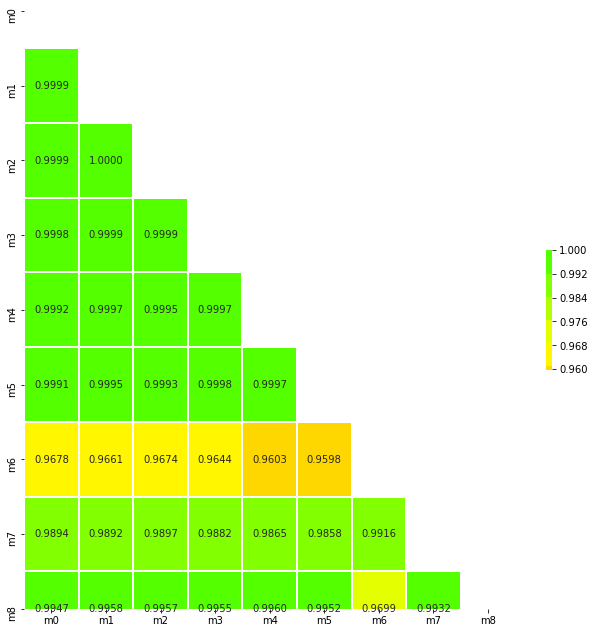

In [6]:
corr = concat_sub.corr()
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(len(cols)+2, len(cols)+2))

# Draw the heatmap with the mask and correct aspect ratio
_ = sns.heatmap(corr,mask=mask,cmap='prism',center=0, linewidths=1,
                annot=True,fmt='.4f', cbar_kws={"shrink":.2})

In [7]:
mean_corr = corr.mean()
mean_corr = mean_corr.sort_values(ascending=True)
mean_corr = mean_corr[:10]
mean_corr

m6    0.971936
m7    0.990415
m8    0.992890
m5    0.993137
m4    0.993408
m3    0.994134
m0    0.994428
m1    0.994453
m2    0.994605
dtype: float64

In [8]:
m_gmean1 = 0
for n in mean_corr.index:
    m_gmean1 += np.log(concat_sub[n])
m_gmean1 = np.exp(m_gmean1/len(mean_corr))

In [9]:
rank = np.tril(corr.values,-1)
rank[rank<0.92] = 1
m = (rank>0).sum() - (rank>0.97).sum()
m_gmean2, s = 0, 0
for n in range(m):
    mx = np.unravel_index(rank.argmin(), rank.shape)
    w = (m-n)/m
    m_gmean2 += w*(np.log(concat_sub.iloc[:,mx[0]])+np.log(concat_sub.iloc[:,mx[1]]))/2
    s += w
    rank[mx] = 1
m_gmean2 = np.exp(m_gmean2/s)

In [10]:
top_mean = 0
s = 0
for n in [0, 2, 6, 7, 8]:
    top_mean += concat_sub.iloc[:,n]*scores[top[n]]
    s += scores[top[n]]
top_mean /= s

In [11]:
m_gmean = np.exp(0.3*np.log(m_gmean1) + 0.2*np.log(m_gmean2) + 0.5*np.log(top_mean))
describe(m_gmean)

DescribeResult(nobs=506691, minmax=(0.0, 1.050787757335592), mean=0.02563211848171236, variance=0.013131810070451402, skewness=7.360854320317396, kurtosis=56.43403757946722)

In [12]:
sample = pd.read_csv('gmean1.csv')
sample['isFraud'] = m_gmean.values
sample.to_csv('temp/blend11.csv', index=False)

In [ ]:
w = sum(scores)
sample['isFraud'] = np.zeros(len(sample))
for f in range(0, len(all_files)):
    temp = pd.read_csv(all_files[f])
    sample['isFraud'] += temp['isFraud']*scores[i]/w
    


In [ ]:
sample.to_csv('temp/blend10.csv', index=False)